# DP1: Code

By Ashish Dhanalakota and Jae Cho

This is the code we used to create and simulate our controller and to plot its motion.

The first step is to import all the packages we need. Numpy, sympy, and scipy help with creating our initial matrices and finding the K matrix and eigenvalues that we seek to use. Time helps with the simulation of our CMG. Matplotlib helps with plotting the motion of the CMG. ae353_cmg is needed to run the pybullet simulator we use.

In [1]:
import numpy as np
from sympy import *
import time
from scipy import signal
import matplotlib.pyplot as plt

import ae353_cmg

Here, we define all our given variables, constants, and equations.

In [2]:
# Defining some variables using sympy
q1, q2, v1, v2, tau = symbols('q1, q2, v1, v2, tau')

# Given constants
J_1z = 0.5    #kg*m^2
J_2x = 0.001  #kg*m^2
J_2z = 0.001  #kg*m^2
J_3x = 0.01   #kg*m^2
J_3y = 0.01   #kg*m^2
J_3z = 0.01   #kg*m^2
m = 1.0       #kg
r = 2.0       #m
g = 9.81      #m/s^2

# Given variables
a1 = -J_3y + 2*J_3z
a2 = 2*J_3y
a3 = -2*g*m*r
a4 = 2*J_1z + 2*J_2z + 2*m*r**2
a5 = 2*J_3z
a6 = (J_3y - J_3z)/2/(J_2x + J_3x)
a7 = -J_3y/(J_2x + J_3x)
a8 = 1/(J_2x + J_3x)

v_rotor = 500 #rad/s

# Given equations
q_ddot1 = (a1*sin(2*q2)*v1*v2 + a2*cos(q2)*v2*v_rotor + a3*sin(q1))/(a4 + a5*cos(q2)*cos(q2))
q_ddot2 = a6*sin(2*q2)*v1**2 + a7*cos(q2)*v1*v_rotor + a8*tau

# Calculations

Here, we are setting our equilibrium points and creating A and B matrices for a state space model.

In [3]:
# Defining our f matrix to take the Jacobian of
f = Matrix([v1, v2, q_ddot1, q_ddot2])

# Equilibrium points
q1e = np.pi #or pi
q2e = 0.
v1e = 0.
v2e = 0.
taue = 0.

# Defining A and B matrices for our state space model
A_num = lambdify([q1, q2, v1, v2, tau], f.jacobian([q1, q2, v1, v2]))
A = A_num(q1e, q2e, v1e, v2e, taue).astype(float)

B_num = lambdify([q1, q2, v1, v2, tau], f.jacobian([tau]))
B = B_num(q1e, q2e, v1e, v2e, taue).astype(float)
A, B

(array([[   0.        ,    0.        ,    1.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,    1.        ],
        [   4.34936821,    0.        ,    0.        ,    1.10840168],
        [   0.        ,    0.        , -454.54545455,    0.        ]]),
 array([[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [90.90909091]]))

This is where we define our eigenvalues and our gain matrix. As you can see, the eigenvalues were determined simply through brute force. We also used a pole placement mthod to determine out gain matrix from the given eigenvalues.

In [4]:
x = symbols('x')

# Our chosen eigenvalues
eig_vals = np.array([-20, -10, -5, -1])

# Our calculations for gain matrix using pole placement
fsf = signal.place_poles(A, B, eig_vals)
K = (fsf.gain_matrix)[0]

K

array([14.951574  , -2.52910296,  1.14573769,  0.396     ])

# Simulation

Run our simulation using the PyBullet simulator.

* `display` being set to `True` means that we can see the display.
* `damping` is set to 0, meaning that there is no external or "frictional" forces acting on the CMG.
* `roll` is set to "pi" so that it is oriented as a wall.
* `mass` is the mass (in kg) of the orange marker attached to the wheel.

In [5]:
simulator = ae353_cmg.Simulator(
    display=True,
    damping=0.,
    load_mass=1.,
    roll=(np.pi / 2),
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


Set the simulation camera view to a side view, enabling the viewer to clearly see the platform and gimbal as they move.

In [6]:
simulator.camera_sideview()

Define a controller that maps sensor measurements to actuator commands. This is where we use the gain matrix and equilibrium points from above.

In [7]:
class Controller:
    def __init__(self):
        pass
    
    def reset(self):
        pass
    
    def run(self, t, platform_angle, platform_velocity, gimbal_angle, gimbal_velocity):
        
        # Defining x matrix
        x = np.array([[platform_angle - np.pi], 
                      [gimbal_angle], 
                      [platform_velocity], 
                      [gimbal_velocity]])
        
        # Calculating input matrix
        u = -K @ x
        gimbal_torque = u[0]
        
        return gimbal_torque

Create an instance of the controller.

In [8]:
controller = Controller()

# Trial 1

Reset the simulator with given initial conditions. Notice how the rotor velocity is kept constant.

In [9]:
simulator.reset(
    platform_angle = np.pi*1.08,
    platform_velocity = 0,
    gimbal_angle = 0,
    gimbal_velocity = 0,
    rotor_velocity = 500.,
)

Reset the controller.

In [10]:
controller.reset()

Run the controller.

In [11]:
data = simulator.run(
    controller,           # Creates an instance of the controller
    max_time=8.0,         # Duration of the simulation
    data_filename=None,   # Not saving this data
    video_filename=None)  # Not saving this video

# Plots

Plot results.

Text(0.5, 0, 'Time (s)')

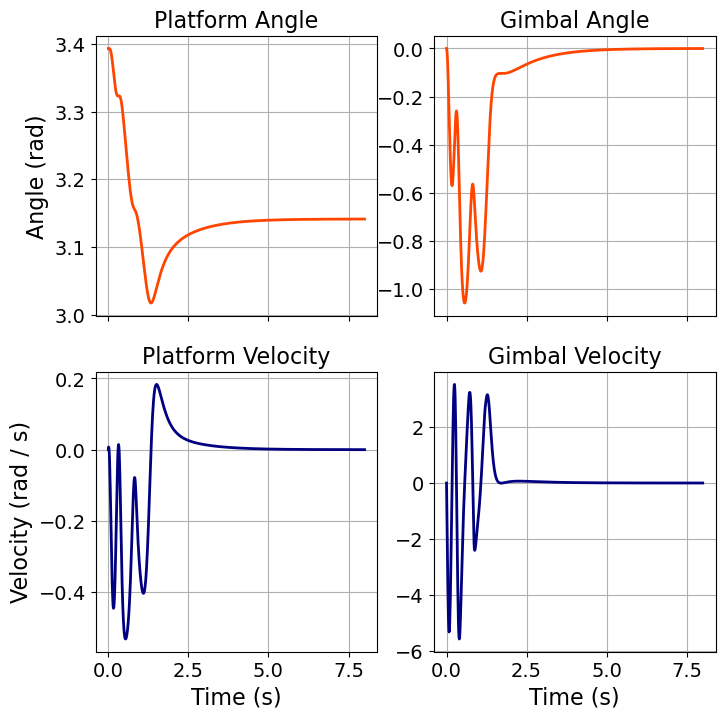

In [12]:
# Create four figures in a 2x2 format, with the same x-values
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True)

# Plot platform angle
axs[0, 0].plot(data['t'], data['platform_angle'], 'orangered', linewidth=2)
axs[0, 0].grid()
axs[0, 0].tick_params(labelsize=14)
axs[0, 0].set_title('Platform Angle', fontsize=16)
axs[0, 0].set_ylabel('Angle (rad)', fontsize=16)

# Plot gimbal angle
axs[0, 1].plot(data['t'], data['gimbal_angle'], 'orangered', linewidth=2)
axs[0, 1].grid()
axs[0, 1].tick_params(labelsize=14)
axs[0, 1].set_title('Gimbal Angle', fontsize=16)

# Plot platform velocity
axs[1, 0].plot(data['t'], data['platform_velocity'], 'navy', linewidth=2)
axs[1, 0].grid()
axs[1, 0].tick_params(labelsize=14)
axs[1, 0].set_title('Platform Velocity', fontsize=16)
axs[1, 0].set_ylabel('Velocity (rad / s)', fontsize=16)
axs[1, 0].set_xlabel('Time (s)', fontsize=16)

# Plot gimbal velocity
axs[1, 1].plot(data['t'], data['gimbal_velocity'], 'navy', linewidth=2)
axs[1, 1].grid()
axs[1, 1].tick_params(labelsize=14)
axs[1, 1].set_title('Gimbal Velocity', fontsize=16)
axs[1, 1].set_xlabel('Time (s)', fontsize=16)

This checks the final angle and velocity values of our gimbal and platform to check whether or not they are truly diverging to the equilibrium points.

In [13]:
print(data['t'][len(data['platform_angle'])-1])
print(data['platform_angle'][len(data['platform_angle'])-1])
print(data['gimbal_angle'][len(data['platform_angle'])-1])
print(data['platform_velocity'][len(data['platform_angle'])-1])
print(data['gimbal_velocity'][len(data['platform_angle'])-1])

8.0
3.1415090266717116
-0.0002491679891320434
8.525066083163963e-05
0.00025431423764625094


# Trial 2

Reset the simulator with given initial conditions. Notice how the rotor velocity is kept constant.

In [14]:
simulator.reset(
    platform_angle = np.pi,
    platform_velocity = 0.55,
    gimbal_angle = 0,
    gimbal_velocity = 0,
    rotor_velocity = 500.,
)

Reset the controller.

In [15]:
controller.reset()

Run the controller.

In [16]:
data = simulator.run(
    controller,           # Creates an instance of the controller
    max_time=8.0,         # Duration of the simulation
    data_filename=None,   # Not saving this data
    video_filename=None)  # Not saving this video

# Plots

Plot results.

Text(0.5, 0, 'Time (s)')

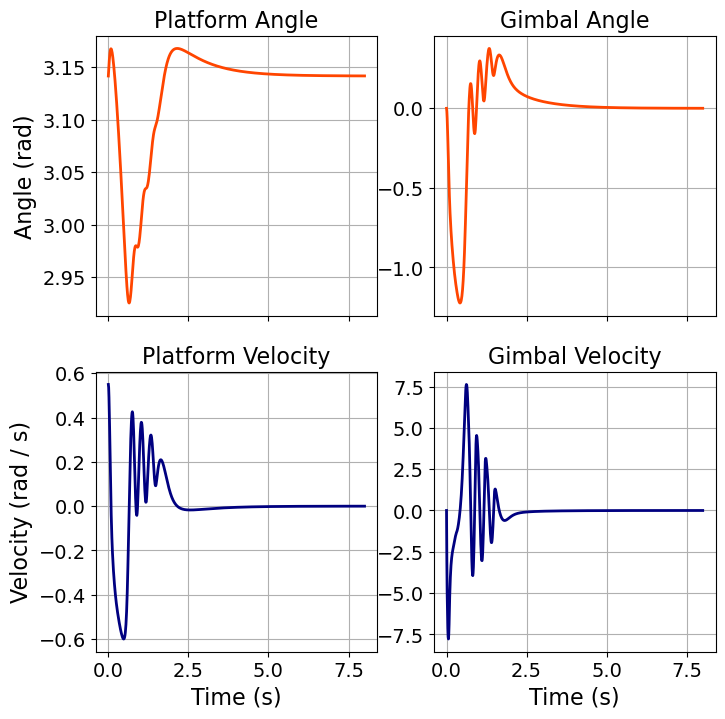

In [17]:
# Create four figures in a 2x2 format, with the same x-values
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True)

# Plot platform angle
axs[0, 0].plot(data['t'], data['platform_angle'], 'orangered', linewidth=2)
axs[0, 0].grid()
axs[0, 0].tick_params(labelsize=14)
axs[0, 0].set_title('Platform Angle', fontsize=16)
axs[0, 0].set_ylabel('Angle (rad)', fontsize=16)

# Plot gimbal angle
axs[0, 1].plot(data['t'], data['gimbal_angle'], 'orangered', linewidth=2)
axs[0, 1].grid()
axs[0, 1].tick_params(labelsize=14)
axs[0, 1].set_title('Gimbal Angle', fontsize=16)

# Plot platform velocity
axs[1, 0].plot(data['t'], data['platform_velocity'], 'navy', linewidth=2)
axs[1, 0].grid()
axs[1, 0].tick_params(labelsize=14)
axs[1, 0].set_title('Platform Velocity', fontsize=16)
axs[1, 0].set_ylabel('Velocity (rad / s)', fontsize=16)
axs[1, 0].set_xlabel('Time (s)', fontsize=16)

# Plot gimbal velocity
axs[1, 1].plot(data['t'], data['gimbal_velocity'], 'navy', linewidth=2)
axs[1, 1].grid()
axs[1, 1].tick_params(labelsize=14)
axs[1, 1].set_title('Gimbal Velocity', fontsize=16)
axs[1, 1].set_xlabel('Time (s)', fontsize=16)

This checks the final angle and velocity values of our gimbal and platform to check whether or not they are truly diverging to the equilibrium points.

In [18]:
print(data['t'][len(data['platform_angle'])-1])
print(data['platform_angle'][len(data['platform_angle'])-1])
print(data['gimbal_angle'][len(data['platform_angle'])-1])
print(data['platform_velocity'][len(data['platform_angle'])-1])
print(data['gimbal_velocity'][len(data['platform_angle'])-1])

8.0
3.141680472366522
0.0002616577154371044
-8.952390882446787e-05
-0.0002670619277630497


# Trial 3

Reset the simulator with given initial conditions. Notice how the rotor velocity is kept constant.

In [19]:
simulator.reset(
    platform_angle = np.pi,
    platform_velocity = 0,
    gimbal_angle = np.pi*0.18,
    gimbal_velocity = 0,
    rotor_velocity = 500.,
)

Reset the controller.

In [20]:
controller.reset()

Run the controller.

In [21]:
data = simulator.run(
    controller,           # Creates an instance of the controller
    max_time=8.0,         # Duration of the simulation
    data_filename=None,   # Not saving this data
    video_filename=None)  # Not saving this video

# Plots

Plot results.

Text(0.5, 0, 'Time (s)')

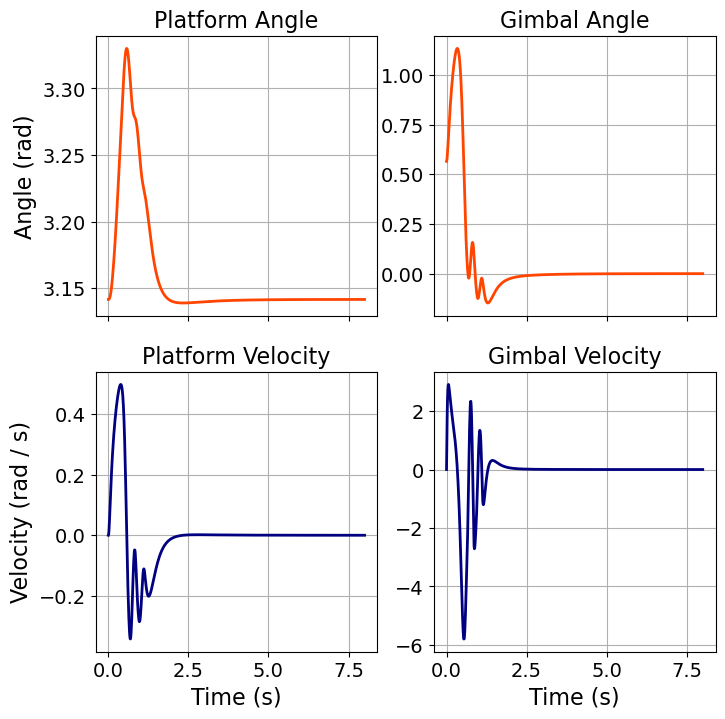

In [22]:
# Create four figures in a 2x2 format, with the same x-values
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True)

# Plot platform angle
axs[0, 0].plot(data['t'], data['platform_angle'], 'orangered', linewidth=2)
axs[0, 0].grid()
axs[0, 0].tick_params(labelsize=14)
axs[0, 0].set_title('Platform Angle', fontsize=16)
axs[0, 0].set_ylabel('Angle (rad)', fontsize=16)

# Plot gimbal angle
axs[0, 1].plot(data['t'], data['gimbal_angle'], 'orangered', linewidth=2)
axs[0, 1].grid()
axs[0, 1].tick_params(labelsize=14)
axs[0, 1].set_title('Gimbal Angle', fontsize=16)

# Plot platform velocity
axs[1, 0].plot(data['t'], data['platform_velocity'], 'navy', linewidth=2)
axs[1, 0].grid()
axs[1, 0].tick_params(labelsize=14)
axs[1, 0].set_title('Platform Velocity', fontsize=16)
axs[1, 0].set_ylabel('Velocity (rad / s)', fontsize=16)
axs[1, 0].set_xlabel('Time (s)', fontsize=16)

# Plot gimbal velocity
axs[1, 1].plot(data['t'], data['gimbal_velocity'], 'navy', linewidth=2)
axs[1, 1].grid()
axs[1, 1].tick_params(labelsize=14)
axs[1, 1].set_title('Gimbal Velocity', fontsize=16)
axs[1, 1].set_xlabel('Time (s)', fontsize=16)

This checks the final angle and velocity values of our gimbal and platform to check whether or not they are truly diverging to the equilibrium points.

In [23]:
print(data['t'][len(data['platform_angle'])-1])
print(data['platform_angle'][len(data['platform_angle'])-1])
print(data['gimbal_angle'][len(data['platform_angle'])-1])
print(data['platform_velocity'][len(data['platform_angle'])-1])
print(data['gimbal_velocity'][len(data['platform_angle'])-1])

8.0
3.1415815302649883
-3.314215527041917e-05
1.133930170969811e-05
3.3826663067319886e-05


# Trial 4

Reset the simulator with given initial conditions. Notice how the rotor velocity is kept constant.

In [24]:
simulator.reset(
    platform_angle = np.pi,
    platform_velocity = 0,
    gimbal_angle = 0,
    gimbal_velocity = 26.35,
    rotor_velocity = 500.,
)

Reset the controller.

In [25]:
controller.reset()

Run the controller.

In [26]:
data = simulator.run(
    controller,           # Creates an instance of the controller
    max_time=8.0,         # Duration of the simulation
    data_filename=None,   # Not saving this data
    video_filename=None)  # Not saving this video

# Plots

Plot results.

Text(0.5, 0, 'Time (s)')

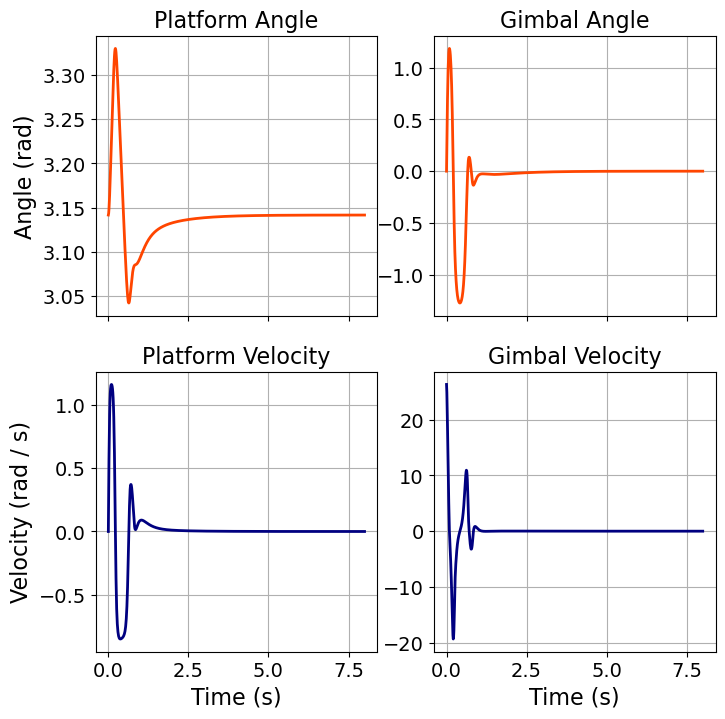

In [27]:
# Create four figures in a 2x2 format, with the same x-values
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True)

# Plot platform angle
axs[0, 0].plot(data['t'], data['platform_angle'], 'orangered', linewidth=2)
axs[0, 0].grid()
axs[0, 0].tick_params(labelsize=14)
axs[0, 0].set_title('Platform Angle', fontsize=16)
axs[0, 0].set_ylabel('Angle (rad)', fontsize=16)

# Plot gimbal angle
axs[0, 1].plot(data['t'], data['gimbal_angle'], 'orangered', linewidth=2)
axs[0, 1].grid()
axs[0, 1].tick_params(labelsize=14)
axs[0, 1].set_title('Gimbal Angle', fontsize=16)

# Plot platform velocity
axs[1, 0].plot(data['t'], data['platform_velocity'], 'navy', linewidth=2)
axs[1, 0].grid()
axs[1, 0].tick_params(labelsize=14)
axs[1, 0].set_title('Platform Velocity', fontsize=16)
axs[1, 0].set_ylabel('Velocity (rad / s)', fontsize=16)
axs[1, 0].set_xlabel('Time (s)', fontsize=16)

# Plot gimbal velocity
axs[1, 1].plot(data['t'], data['gimbal_velocity'], 'navy', linewidth=2)
axs[1, 1].grid()
axs[1, 1].tick_params(labelsize=14)
axs[1, 1].set_title('Gimbal Velocity', fontsize=16)
axs[1, 1].set_xlabel('Time (s)', fontsize=16)

This checks the final angle and velocity values of our gimbal and platform to check whether or not they are truly diverging to the equilibrium points.

In [28]:
print(data['t'][len(data['platform_angle'])-1])
print(data['platform_angle'][len(data['platform_angle'])-1])
print(data['gimbal_angle'][len(data['platform_angle'])-1])
print(data['platform_velocity'][len(data['platform_angle'])-1])
print(data['gimbal_velocity'][len(data['platform_angle'])-1])

8.0
3.1415741069167944
-5.5260160182378296e-05
1.8906786240661056e-05
5.6401485518201344e-05


# Trial 5

Reset the simulator with given initial conditions. Notice how the rotor velocity is kept constant.

In [29]:
simulator.reset(
    platform_angle = np.pi*0.958,
    platform_velocity = -0.25,
    gimbal_angle = np.pi*0.0285,
    gimbal_velocity = 2,
    rotor_velocity = 500.,
)

Reset the controller.

In [30]:
controller.reset()

Run the controller.

In [31]:
data = simulator.run(
    controller,           # Creates an instance of the controller
    max_time=10.0,         # Duration of the simulation
    data_filename=None,   # Not saving this data
    video_filename=None)  # Not saving this video

# Plots

Plot results.

Text(0.5, 0, 'Time (s)')

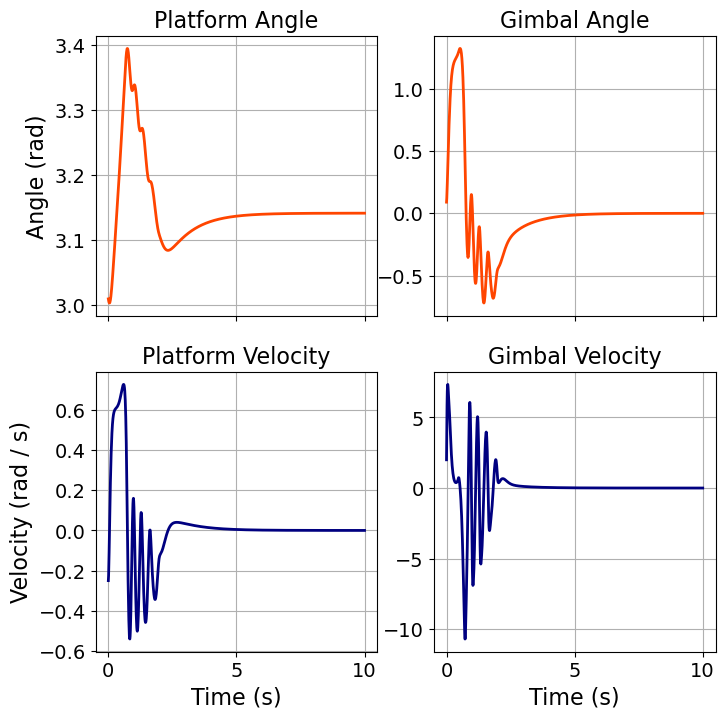

In [32]:
# Create four figures in a 2x2 format, with the same x-values
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True)

# Plot platform angle
axs[0, 0].plot(data['t'], data['platform_angle'], 'orangered', linewidth=2)
axs[0, 0].grid()
axs[0, 0].tick_params(labelsize=14)
axs[0, 0].set_title('Platform Angle', fontsize=16)
axs[0, 0].set_ylabel('Angle (rad)', fontsize=16)

# Plot gimbal angle
axs[0, 1].plot(data['t'], data['gimbal_angle'], 'orangered', linewidth=2)
axs[0, 1].grid()
axs[0, 1].tick_params(labelsize=14)
axs[0, 1].set_title('Gimbal Angle', fontsize=16)

# Plot platform velocity
axs[1, 0].plot(data['t'], data['platform_velocity'], 'navy', linewidth=2)
axs[1, 0].grid()
axs[1, 0].tick_params(labelsize=14)
axs[1, 0].set_title('Platform Velocity', fontsize=16)
axs[1, 0].set_ylabel('Velocity (rad / s)', fontsize=16)
axs[1, 0].set_xlabel('Time (s)', fontsize=16)

# Plot gimbal velocity
axs[1, 1].plot(data['t'], data['gimbal_velocity'], 'navy', linewidth=2)
axs[1, 1].grid()
axs[1, 1].tick_params(labelsize=14)
axs[1, 1].set_title('Gimbal Velocity', fontsize=16)
axs[1, 1].set_xlabel('Time (s)', fontsize=16)

This checks the final angle and velocity values of our gimbal and platform to check whether or not they are truly diverging to the equilibrium points.

In [33]:
print(data['t'][len(data['platform_angle'])-1])
print(data['platform_angle'][len(data['platform_angle'])-1])
print(data['gimbal_angle'][len(data['platform_angle'])-1])
print(data['platform_velocity'][len(data['platform_angle'])-1])
print(data['gimbal_velocity'][len(data['platform_angle'])-1])

10.0
3.141564287170361
-8.451827940598597e-05
2.8917198501488295e-05
8.626389288258204e-05


# Trial 6

Reset the simulator with given initial conditions. Notice how the rotor velocity is kept constant.

In [34]:
simulator.reset(
    platform_angle = np.pi*0.958,
    platform_velocity = -0.3,
    gimbal_angle = np.pi*0.0285,
    gimbal_velocity = 2,
    rotor_velocity = 500.,
)

Reset the controller.

In [35]:
controller.reset()

Run the controller.

In [36]:
data = simulator.run(
    controller,           # Creates an instance of the controller
    max_time=8.0,         # Duration of the simulation
    data_filename=None,   # Not saving this data
    video_filename=None)  # Not saving this video

# Plots

Plot results.

Text(0.5, 0, 'Time (s)')

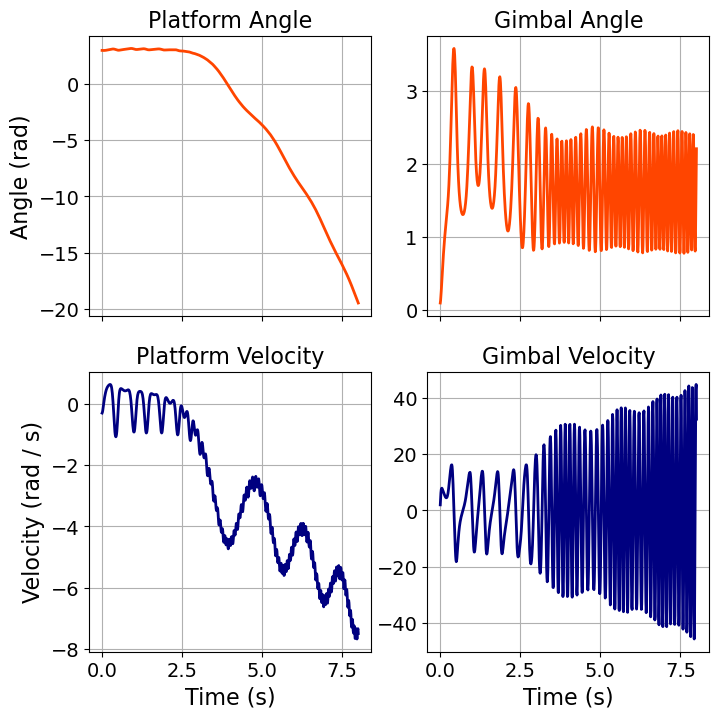

In [37]:
# Create four figures in a 2x2 format, with the same x-values
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True)

# Plot platform angle
axs[0, 0].plot(data['t'], data['platform_angle'], 'orangered', linewidth=2)
axs[0, 0].grid()
axs[0, 0].tick_params(labelsize=14)
axs[0, 0].set_title('Platform Angle', fontsize=16)
axs[0, 0].set_ylabel('Angle (rad)', fontsize=16)

# Plot gimbal angle
axs[0, 1].plot(data['t'], data['gimbal_angle'], 'orangered', linewidth=2)
axs[0, 1].grid()
axs[0, 1].tick_params(labelsize=14)
axs[0, 1].set_title('Gimbal Angle', fontsize=16)

# Plot platform velocity
axs[1, 0].plot(data['t'], data['platform_velocity'], 'navy', linewidth=2)
axs[1, 0].grid()
axs[1, 0].tick_params(labelsize=14)
axs[1, 0].set_title('Platform Velocity', fontsize=16)
axs[1, 0].set_ylabel('Velocity (rad / s)', fontsize=16)
axs[1, 0].set_xlabel('Time (s)', fontsize=16)

# Plot gimbal velocity
axs[1, 1].plot(data['t'], data['gimbal_velocity'], 'navy', linewidth=2)
axs[1, 1].grid()
axs[1, 1].tick_params(labelsize=14)
axs[1, 1].set_title('Gimbal Velocity', fontsize=16)
axs[1, 1].set_xlabel('Time (s)', fontsize=16)

This checks the final angle and velocity values of our gimbal and platform to check whether or not they are truly diverging to the equilibrium points.

In [38]:
print(data['t'][len(data['platform_angle'])-1])
print(data['platform_angle'][len(data['platform_angle'])-1])
print(data['gimbal_angle'][len(data['platform_angle'])-1])
print(data['platform_velocity'][len(data['platform_angle'])-1])
print(data['gimbal_velocity'][len(data['platform_angle'])-1])

8.0
-19.49853902532484
2.206823554332605
-7.497054885661386
32.519686781494656
